In [27]:
 URL <- "http://rdatasciencecases.org/Data/offline.final.trace.txt"
 download.file(url=URL,destfile = "offlineFinalTrace.txt")

In [28]:
options(digits = 3)
# Read in the data
txt = readLines("offlineFinalTrace.txt")

In [29]:
sum(substr(txt, 1, 1) == "#")
length(txt)
strsplit(txt[4], ";")[[1]] # Examine structure the first data line

[1] 5312

[1] 151392

[1] "t=1139643118358"                    "id=00:02:2D:21:0F:33"              
 [3] "pos=0.0,0.0,0.0"                    "degree=0.0"                        
 [5] "00:14:bf:b1:97:8a=-38,2437000000,3" "00:14:bf:b1:97:90=-56,2427000000,3"
 [7] "00:0f:a3:39:e1:c0=-53,2462000000,3" "00:14:bf:b1:97:8d=-65,2442000000,3"
 [9] "00:14:bf:b1:97:81=-65,2422000000,3" "00:14:bf:3b:c7:c6=-66,2432000000,3"
[11] "00:0f:a3:39:dd:cd=-75,2412000000,3" "00:0f:a3:39:e0:4b=-78,2462000000,3"
[13] "00:0f:a3:39:e2:10=-87,2437000000,3" "02:64:fb:68:52:e6=-88,2447000000,1"
[15] "02:00:42:55:31:00=-84,2457000000,1"

In [4]:
tokens = strsplit(txt[4], "[;=,]")[[1]] #split at a ; = or , character
tokens[1:10] # information about the handheld device
tokens[c(2, 4, 6:8, 10)] # extract the values of these variables
tokens[ - ( 1:10 ) ] # recorded signals within this observation
tmp = matrix(tokens[ - (1:10) ], ncol = 4, byrow = TRUE)

[1] "t"                 "1139643118358"     "id"               
 [4] "00:02:2D:21:0F:33" "pos"               "0.0"              
 [7] "0.0"               "0.0"               "degree"           
[10] "0.0"

[1] "1139643118358"     "00:02:2D:21:0F:33" "0.0"              
[4] "0.0"               "0.0"               "0.0"

[1] "00:14:bf:b1:97:8a" "-38"               "2437000000"       
 [4] "3"                 "00:14:bf:b1:97:90" "-56"              
 [7] "2427000000"        "3"                 "00:0f:a3:39:e1:c0"
[10] "-53"               "2462000000"        "3"                
[13] "00:14:bf:b1:97:8d" "-65"               "2442000000"       
[16] "3"                 "00:14:bf:b1:97:81" "-65"              
[19] "2422000000"        "3"                 "00:14:bf:3b:c7:c6"
[22] "-66"               "2432000000"        "3"                
[25] "00:0f:a3:39:dd:cd" "-75"               "2412000000"       
[28] "3"                 "00:0f:a3:39:e0:4b" "-78"              
[31] "2462000000"        "3"                 "00:0f:a3:39:e2:10"
[34] "-87"               "2437000000"        "3"                
[37] "02:64:fb:68:52:e6" "-88"               "2447000000"       
[40] "1"                 "02:00:42:55:31:00" "-84"              
[43] "2457000000"        "1"

In [30]:
# Build a matrix from the recorded signals
mat = cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp),
                   ncol = 6, byrow = TRUE), 
            tmp)

dim(mat) # confirm dimension of the matrix

ERROR: Error in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, : non-numeric matrix extent


In [6]:
mat

1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38,2437000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:90,-56,2427000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-53,2462000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8d,-65,2442000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:81,-65,2422000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:3b:c7:c6,-66,2432000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:dd:cd,-75,2412000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:e0:4b,-78,2462000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:e2:10,-87,2437000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,02:64:fb:68:52:e6,-88,2447000000,1
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,02:00:42:55:31:00,-84,2457000000,1


In [ ]:
processLine =
  function(x)
  {
    tokens = strsplit(x, "[;=,]")[[1]]
    tmp = matrix(tokens[ - (1:10) ], ncol = 4, byrow = TRUE)
    cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp),
                 ncol = 6, byrow = TRUE), tmp)
  }

In [8]:
tmp = lapply(txt[4:20], processLine) # make sure it works on the first 16 lines
sapply(tmp, nrow) # Find the number of records per row

# Turn these individual matrices into a single data frame
offline = as.data.frame(do.call("rbind", tmp)) # faster than a for loop!
dim(offline)
# Here we go - reading in some data
lines = txt[ substr(txt, 1, 1) != "#" ]
tmp = lapply(lines, processLine)


[1] 11 10 10 11  9 10  9  9 10 11 11  9  9  9  8 10 14

[1] 170  10

Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”

In [ ]:
processLine = function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
  
  if (length(tokens) == 10) 
  return(NULL)
  
  tmp = matrix(tokens[ - (1:10) ], , 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6, 
  byrow = TRUE), tmp)
}

In [31]:
options(error = recover, warn = 1) # reset options
# Create the new data set
tmp = lapply(lines, processLine)
offline = as.data.frame(do.call("rbind", tmp), 
stringsAsFactors = FALSE)
dim(offline)

[1] 1181628      10

In [32]:
names(offline) = c("time", "scanMac", "posX", "posY", "posZ", 
                   "orientation", "mac", "signal", 
                   "channel", "type")

numVars = c("time", "posX", "posY", "posZ", 
            "orientation", "signal")
offline[ numVars ] =  lapply(offline[ numVars ], as.numeric)

offline = offline[ offline$type == "3", ]
offline = offline[ , "type" != names(offline) ]
dim(offline)


[1] 978443      9

time1       time2     scanMac        posX        posY        posZ 
   "POSIXt"   "POSIXct" "character"   "numeric"   "numeric"   "numeric" 
orientation         mac      signal     channel     rawTime 
  "numeric" "character"   "numeric" "character"   "numeric"

      time                          posX           posY           posZ  
 Min.   :2006-02-11 13:01:58   Min.   : 0.0   Min.   : 0.0   Min.   :0  
 1st Qu.:2006-02-11 18:51:27   1st Qu.: 2.0   1st Qu.: 3.0   1st Qu.:0  
 Median :2006-02-12 01:27:58   Median :12.0   Median : 6.0   Median :0  
 Mean   :2006-02-16 20:27:37   Mean   :13.5   Mean   : 5.9   Mean   :0  
 3rd Qu.:2006-02-19 20:22:40   3rd Qu.:23.0   3rd Qu.: 8.0   3rd Qu.:0  
 Max.   :2006-03-10 02:11:10   Max.   :33.0   Max.   :13.0   Max.   :0  
  orientation      signal     
 Min.   :  0   Min.   :-99.0  
 1st Qu.: 90   1st Qu.:-69.0  
 Median :180   Median :-60.0  
 Mean   :167   Mean   :-61.7  
 3rd Qu.:270   3rd Qu.:-53.0  
 Max.   :360   Max.   :-25.0  

                mac               channel                    scanMac      
 00:0f:a3:39:e1:c0:145862   2462000000:189774   00:02:2D:21:0F:33:978443  
 00:0f:a3:39:dd:cd:145619   2437000000:152124                             
 00:14:bf:b1:97:8a:132962   2412000000:145619                             
 00:14:bf:3b:c7:c6:126529   2432000000:126529                             
 00:14:bf:b1:97:90:122315   2427000000:122315                             
 00:14:bf:b1:97:8d:121325   2442000000:121325                             
 (Other)          :183831   (Other)   :120757                             

[1] 203

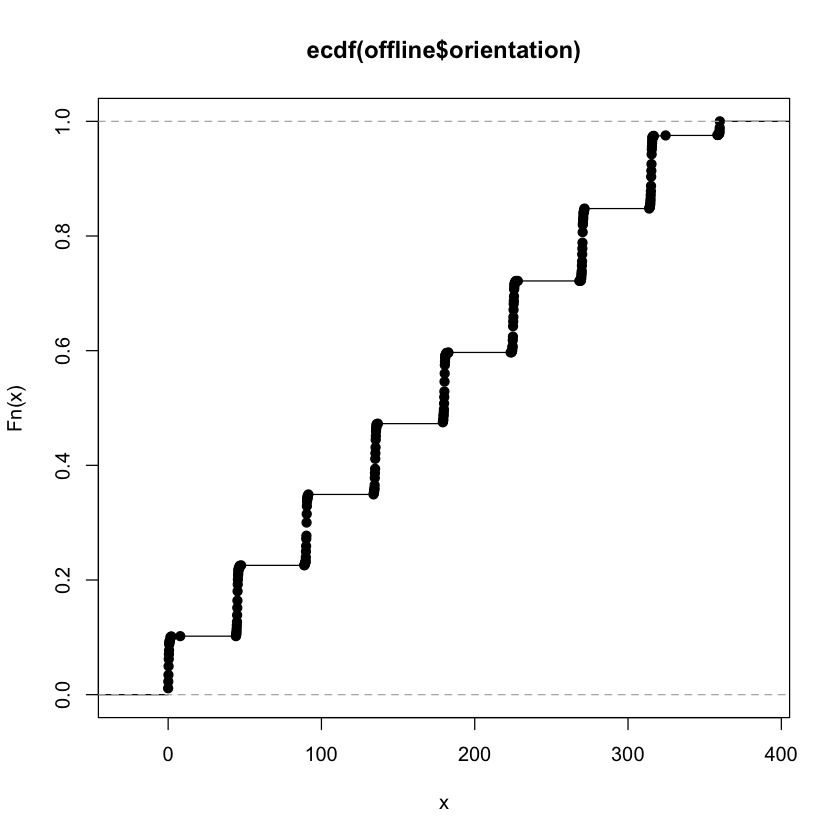

In [12]:
offline$rawTime = offline$time
offline$time = offline$time/1000
class(offline$time) = c("POSIXt", "POSIXct")

unlist(lapply(offline, class))

summary(offline[, numVars])

 summary(sapply(offline[ , c("mac", "channel", "scanMac")],
                as.factor))

offline = offline[ , !(names(offline) %in% c("scanMac", "posZ"))]

length(unique(offline$orientation))

plot(ecdf(offline$orientation))


In [33]:
pdf(file = "Geo_ECDFOrientation.pdf", width = 10, height = 7)
oldPar = par(mar = c(4, 4, 1, 1))
plot(ecdf(offline$orientation), pch = 19, cex = 0.3,
     xlim = c(-5, 365), axes = FALSE,
     xlab = "orientation", ylab = "Empirical CDF", main = "")
box()
axis(2)
axis(side = 1, at = seq(0, 360, by = 45))
par(oldPar)
dev.off()

pdf 
  2

In [14]:
pdf(file = "Geo_DensityOrientation.pdf", width = 10, height = 5)
oldPar = par(mar = c(4, 4, 1, 1))
plot(density(offline$orientation, bw = 2), 
 xlab = "orientation", main = "")
par(oldPar)
dev.off()

roundOrientation = function(angles) {
  refs = seq(0, by = 45, length  = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}

offline$angle = roundOrientation(offline$orientation)

pdf(file = "Geo_BoxplotAngle.pdf", width = 10)
oldPar = par(mar = c(4, 4, 1, 1))

par(oldPar)
dev.off()

pdf 
  2

pdf 
  2

In [34]:
c(length(unique(offline$mac)), length(unique(offline$channel)))

table(offline$mac)

subMacs = names(sort(table(offline$mac), decreasing = TRUE))[1:7]
offline = offline[ offline$mac %in% subMacs, ]

macChannel = with(offline, table(mac, channel))
apply(macChannel, 1, function(x) sum(x > 0))

offline = offline[ , "channel" != names(offline)]

locDF = with(offline, 
             by(offline, list(posX, posY), function(x) x))
length(locDF)

[1] 12  8


00:04:0e:5c:23:fc 00:0f:a3:39:dd:cd 00:0f:a3:39:e0:4b 00:0f:a3:39:e1:c0 
              418            145619             43508            145862 
00:0f:a3:39:e2:10 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
            19162            126529            120339            132962 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 00:30:bd:f8:7f:c5 00:e0:63:82:8b:a9 
           121325            122315               301               103 

00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
                1                 1                 1                 1 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
                1                 1                 1

[1] 476

In [16]:
sum(sapply(locDF, is.null))

locDF = locDF[ !sapply(locDF, is.null) ]

length(locDF)

locCounts = sapply(locDF, nrow)

locCounts = sapply(locDF, 
                   function(df) 
                     c(df[1, c("posX", "posY")], count = nrow(df)))

class(locCounts)

dim(locCounts)

locCounts[ , 1:8]

pdf(file = "Geo_XYByCount.pdf", width = 10)
oldPar = par(mar = c(3.1, 3.1, 1, 1))

locCounts = t(locCounts)
plot(locCounts, type = "n", xlab = "", ylab = "")
text(locCounts, labels = locCounts[,3], cex = .8, srt = 45)

par(oldPar)
dev.off()

[1] 310

[1] 166

[1] "matrix"

[1]   3 166

posX,0,1,2,0,1,2,0,1
posY,0,0,0,1,1,1,2,2
count,5505,5505,5506,5524,5543,5558,5503,5564


pdf 
  2

In [47]:
readData = 
  function(filename = 'offlineFinalTrace.txt', 
           subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81"))
  {
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
     # keep only signals from access points
    offline = offline[ offline$type == "3", ]
    
    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline = offline[ , !( names(offline) %in% dropVars ) ]
    
    # drop more unwanted access points
    offline = offline[ offline$mac %in% subMacs, ]
    
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)

    # convert time to POSIX
    offline$rawTime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline$angle = roundOrientation(offline$orientation)
      
    return(offline)
  }

In [48]:
sx = readData()
sx

,time,posX,posY,orientation,mac,signal,rawTime,angle
1,2006-02-11 13:01:58,0,0,0,00:14:bf:b1:97:8a,-38,1.14e+12,0
2,2006-02-11 13:01:58,0,0,0,00:14:bf:b1:97:90,-56,1.14e+12,0
3,2006-02-11 13:01:58,0,0,0,00:0f:a3:39:e1:c0,-53,1.14e+12,0
4,2006-02-11 13:01:58,0,0,0,00:14:bf:b1:97:8d,-65,1.14e+12,0
5,2006-02-11 13:01:58,0,0,0,00:14:bf:b1:97:81,-65,1.14e+12,0
6,2006-02-11 13:01:58,0,0,0,00:14:bf:3b:c7:c6,-66,1.14e+12,0
7,2006-02-11 13:01:58,0,0,0,00:0f:a3:39:dd:cd,-75,1.14e+12,0
12,2006-02-11 13:01:58,0,0,0,00:14:bf:b1:97:8a,-38,1.14e+12,0
13,2006-02-11 13:01:58,0,0,0,00:0f:a3:39:e1:c0,-54,1.14e+12,0
14,2006-02-11 13:01:58,0,0,0,00:14:bf:b1:97:90,-56,1.14e+12,0


In [44]:
offlineRedo = readData()

identical(offline, offlineRedo)

pdf(file = "Geo_BoxplotSignalByMacAngle.pdf", width = 7)
oldPar = par(mar = c(3.1, 3, 1, 1))



[1] FALSE

In [46]:
offline

,time,scanMac,posX,posY,posZ,orientation,mac,signal
1,1.14e+12,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:b1:97:8a,-38
2,1.14e+12,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:b1:97:90,-56
3,1.14e+12,00:02:2D:21:0F:33,0,0,0,0,00:0f:a3:39:e1:c0,-53
4,1.14e+12,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:b1:97:8d,-65
5,1.14e+12,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:b1:97:81,-65
6,1.14e+12,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:3b:c7:c6,-66
7,1.14e+12,00:02:2D:21:0F:33,0,0,0,0,00:0f:a3:39:dd:cd,-75
12,1.14e+12,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:b1:97:8a,-38
13,1.14e+12,00:02:2D:21:0F:33,0,0,0,0,00:0f:a3:39:e1:c0,-54
14,1.14e+12,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:b1:97:90,-56


In [ ]:
library(lattice)
bwplot(signal ~ factor(angle) | mac, data = offline, 
       subset = posX == 2 & posY == 12 
                & mac != "00:0f:a3:39:dd:cd", 
       layout = c(2,3))

par(oldPar)
dev.off()

In [ ]:
summary(offline$signal)

pdf(file = "Geo_DensitySignalByMacAngle.pdf", width = 8, height = 12)
oldPar = par(mar = c(3.1, 3, 1, 1))

densityplot( ~ signal | mac + factor(angle), data = offline,
             subset = posX == 24 & posY == 4 & 
                         mac != "00:0f:a3:39:dd:cd",
             bw = 0.5, plot.points = FALSE)

par(oldPar)
dev.off()

#offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

offline$posXY = paste(offline$posX, offline$posY, sep = "-")

byLocAngleAP = with(offline, 
                    by(offline, list(posXY, angle, mac), 
                       function(x) x))

In [22]:
signalSummary = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

offlineSummary = do.call("rbind", signalSummary) 

In [23]:
pdf(file = "Geo_BoxplotSignalSDByAvg.pdf", width = 10)
oldPar = par(mar = c(3.1, 3, 1, 1))

breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
       data = offlineSummary, 
       subset = mac != "00:0f:a3:39:dd:cd",
       xlab = "Mean Signal", ylab = "SD Signal")

par(oldPar)
dev.off()

pdf(file = "Geo_ScatterMean-Median.pdf", width = 10)
oldPar = par(mar = c(4.1, 4.1, 1, 1))

with(offlineSummary,
     smoothScatter((avgSignal - medSignal) ~ num,
                   xlab = "Number of Observations", 
                   ylab = "mean - median"))
abline(h = 0, col = "#984ea3", lwd = 2)

lo.obj = 
  with(offlineSummary,
       loess(diff ~ num, 
             data = data.frame(diff = (avgSignal - medSignal),
                               num = num)))

lo.obj.pr = predict(lo.obj, newdata = data.frame(num = (70:120)))
lines(x = 70:120, y = lo.obj.pr, col = "#4daf4a", lwd = 2)

par(oldPar)
dev.off()

pdf 
  2

pdf 
  2

In [25]:
oneAPAngle = subset(offlineSummary, 
                    mac == subMacs[5] & angle == 0)




In [26]:
library(fields)
smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
               oneAPAngle$avgSignal)

vizSmooth = predictSurface(smoothSS)

plot.surface(vizSmooth, type = "C")

points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)

ERROR: Error in library(fields): there is no package called ‘fields’
